# Objectives

1. Run Treemmer (Complete)
1. Plot Taxa vs. RTL
1. Run Treemmer (Target)
1. Prune Tree, Dataframe, Alignment
1. Plot Tree Comparison

---
# Setup

## Module Imports

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from Bio import Phylo, Align, AlignIO
import seaborn as sns
import copy
import numpy as np
import random

## Input Paths

In [87]:
tree_path = "../../docs/results/latest/parse_tree/parse_tree.nwk"
aln_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"
tree_df_path = "../../docs/results/latest/parse_tree/parse_tree.tsv"
treemmer_path = "../scripts/Treemmer.py"

auspice_config_path = "../../config/auspice_config.json" 
auspice_colors_path="../../docs/results/latest/parse_tree/parse_tree_colors.tsv"
auspice_latlons_path="../../docs/results/latest/parse_tree/parse_tree_latlon.tsv"
auspice_remote_dir_path = "../../auspice/"

outdir = "../../docs/results/latest/treemmer"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Variables

In [3]:
from config import *

SCRIPT_NAME = "treemmer"

SEED = 70262122
np.random.seed(SEED)
random.seed(SEED)

## Import Tree and Dataframe

In [131]:
tree_pre = Phylo.read(tree_path, "newick")
tree_pre.ladderize(reverse=False)

tree_df_pre = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df_pre.fillna(NO_DATA_CHAR, inplace=True)
tree_df_pre.set_index("Name", inplace=True)
tree_df_pre

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number
Name,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,black,0.000000,17.820516,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.850400e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0
NODE1,100,85,1.327080e-05,black,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.248400e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0
NODE2,100,94.6,1.363640e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE630,19,48.8,6.380000e-08,black,0.000076,632.750000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,grey,0.000076,632.000000,PY-113,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141506,KEEP: Assembly Modern,1
NODE631,37,49.6,2.936000e-07,black,0.000076,633.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


---
# 1. Run Treemmer (Complete)

In [5]:
# Remove old treemmer results
old_treemmer_files = os.popen("ls {}*".format(os.path.join(outdir,"treemmer"))).read().strip().split("\n")
for file in old_treemmer_files:
    if not file: continue
    print("Deleting old treemmer file:", file)
    os.remove(file)
    
# Copy over the tree to the new directory
out_path_tree = os.path.join(outdir, "treemmer.nwk")
os.system("cp {old_tree} {new_tree}".format(old_tree = tree_path, new_tree = out_path_tree))

# Run treemmer
os.system("python3 {treemmer} {tree} --verbose 1 --plot_complete".format(treemmer=treemmer_path, tree=out_path_tree))

Deleting old treemmer file: ../../docs/results/latest/treemmer/treemmer.nwk
Deleting old treemmer file: ../../docs/results/latest/treemmer/treemmer_res_1_LD.txt
Deleting old treemmer file: ../../docs/results/latest/treemmer/treemmer_res_1_TLD.pdf
Deleting old treemmer file: ../../docs/results/latest/treemmer/treemmer_rtl.svg


0

## Create a dataframe for the output

In [6]:
treemmer_df_path = os.path.join(outdir, "treemmer_res_1_LD.txt")
treemmer_df = pd.read_csv(treemmer_df_path, sep='\t', header=None)
treemmer_df.columns = ["rtl", "taxa"]
treemmer_df

,rtl,taxa
0,1.000000,630
1,1.000000,629
2,1.000000,628
3,1.000000,627
4,1.000000,626
...,...,...
626,0.184355,7
627,0.169192,6
628,0.147618,5
629,0.104741,4


---
# 2. Plot Taxa vs. RTL

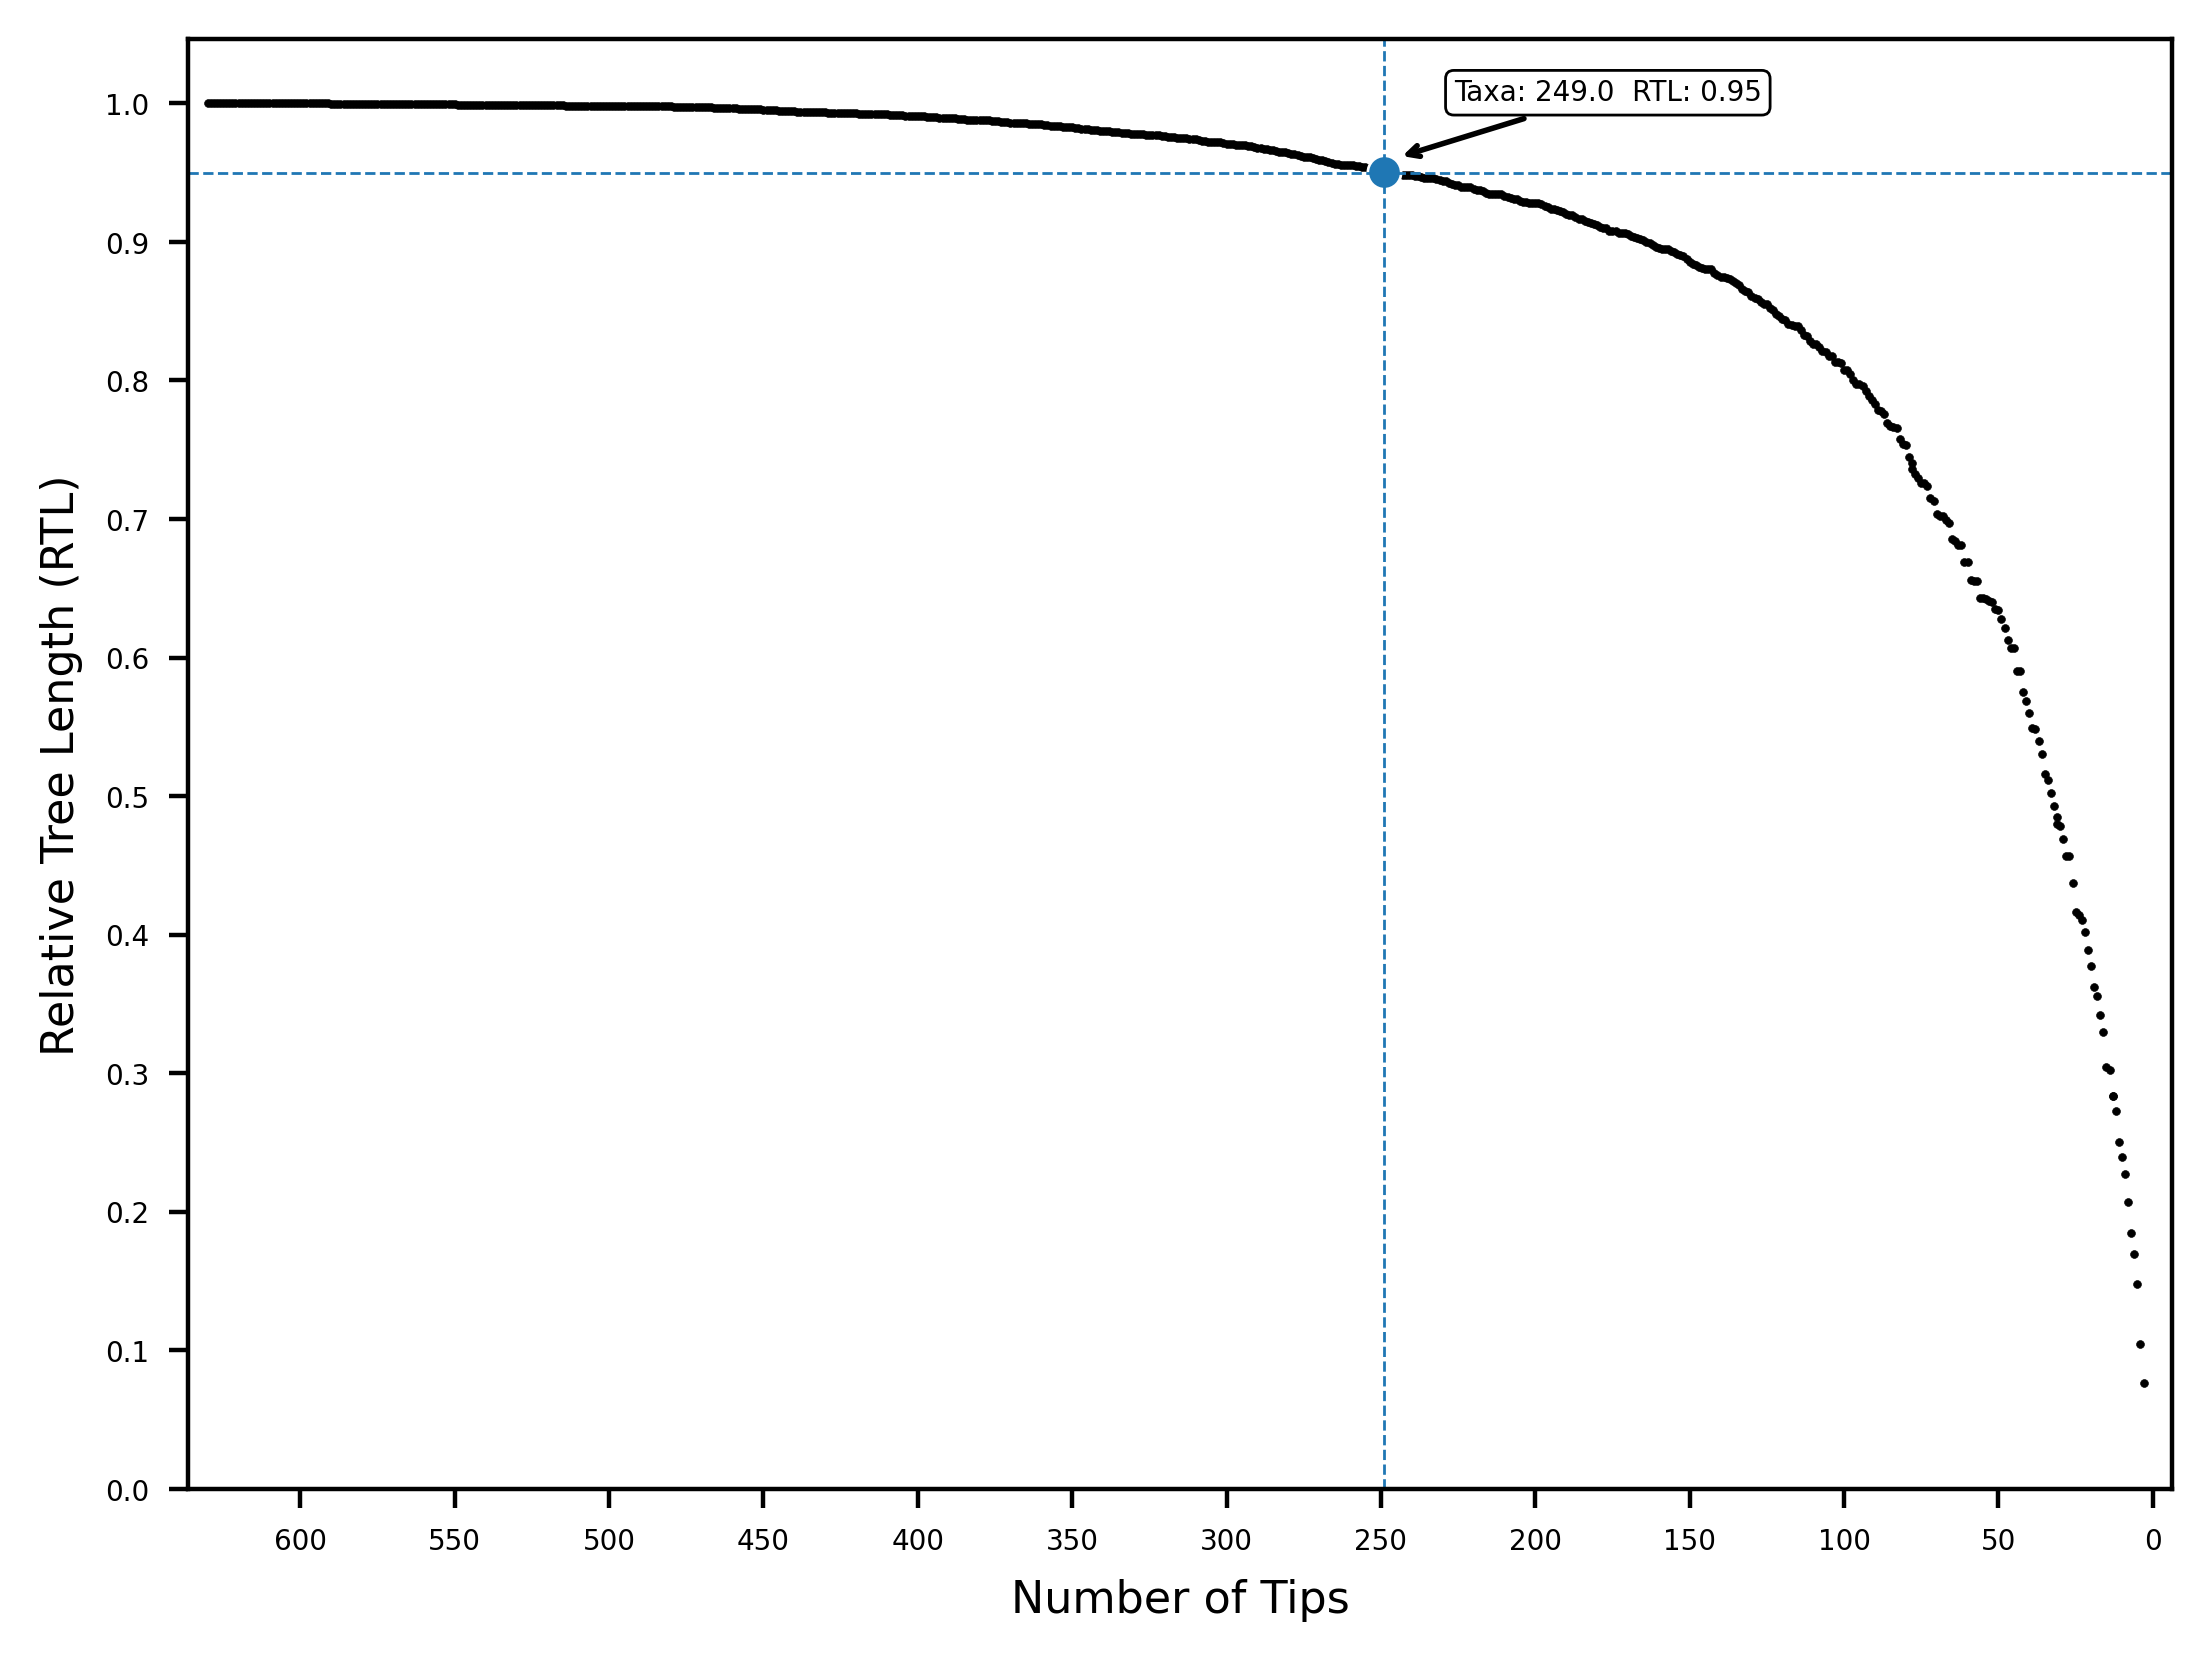

In [7]:
target_taxa = max(treemmer_df["taxa"])
target_iloc = 0

# Identify the number of taxa
for rec in treemmer_df.iterrows():
    iloc = rec[0]
    rtl = rec[1]["rtl"]
    taxa = rec[1]["taxa"] 
    # Stop once threshold is passed
    if rtl >= TARGET_RTL:
        target_taxa = taxa   
        target_iloc = iloc
    else:
        break
        
# Setup the figure        
fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize)

# Plot Taxa vs. RTL
sns.scatterplot(data=treemmer_df, 
                x="taxa", 
                y="rtl", 
                color="black", 
                s=2, 
                edgecolor="black",
                ax=ax1)

# Plot the candidate point
sns.scatterplot(data=treemmer_df.iloc[[target_iloc]], 
                x="taxa", 
                y="rtl")

ax1.set_xlabel("Number of Tips")
ax1.set_ylabel("Relative Tree Length (RTL)")


ax1.set_xticks([t for t in range(0,max(treemmer_df["taxa"]),50)])
ax1.set_yticks([t/10 for t in range(0,11,1)])

x_buffer = max(treemmer_df["taxa"]) * 0.01
y_buffer = max(treemmer_df["rtl"]) * 0.01
ax1.set_xlim(max(treemmer_df["taxa"]) + x_buffer, 0 - x_buffer)

ax1.axhline(TARGET_RTL, linestyle="--")
ax1.axvline(target_taxa, linestyle="--")

# Annotation
ax1.annotate("Taxa: {}  RTL: {}".format(target_taxa, TARGET_RTL), 
             xy=(target_taxa / 1.01, TARGET_RTL * 1.01), 
             xycoords="data",      
             va="bottom", 
             ha="left",
             xytext=(target_taxa / 1.10, TARGET_RTL * 1.05), 
             textcoords='data',     
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),             
             bbox=dict(boxstyle="round", fc="w", lw=0.5))

# Export
out_path = os.path.join(outdir, SCRIPT_NAME + "_rtl." + FMT)
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

---
# 3. Run Treemmer (Target)

In [8]:
os.system("python3 {treemmer} {tree} --stop_at_X_leaves {stop} --verbose 0".format(treemmer=treemmer_path, 
                                                                                                    tree=out_path_tree,
                                                                                                    stop=int(target_taxa))
                                                                                                   )

0

---
# 4. Prune Tree, Dataframe, Alignment

In [123]:
# import tree
tree = Phylo.read(tree_path, "newick")
tree.ladderize(reverse=False)

# import datarfame
tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index("Name", inplace=True)

# import treemmer tree
treemmer_path = os.path.join(outdir, "treemmer_trimmed_tree_X_{}.nwk".format(int(target_taxa)))
treemmer_tree = Phylo.read(treemmer_path, "newick")
treemmer_tree.ladderize(reverse=False)

# setup new alignment
align = AlignIO.read(aln_path, format="fasta")
treemmer_seq = []

# drop internal nodes from dataframe (sync tree and df)
for t in tree.find_clades():
    if "NODE" in t.name:
        tree_df.drop(t.name, inplace=True)
        
# List of tips to keep and prune
treemmer_tips_keep = [t.name for t in treemmer_tree.get_terminals()]
treemmer_tips_prune = [t.name for t in tree.get_terminals() if t.name not in treemmer_tips_keep]

# drop pruned tips from dataframe
for t in treemmer_tips_prune:
    tree_df.drop(t, inplace=True)
    
# drop pruned tips from tree
for t in treemmer_tips_prune:
    tree.prune(t)
    
# create new alignment
for t in treemmer_tips_keep:
    for i in range(0, len(align)):
        if align[i].id == t:
            treemmer_seq.append(align[i])

treemmer_align = Align.MultipleSeqAlignment(treemmer_seq)
            
print("keep:\t", len(treemmer_tips_keep))
# Tree might have a bit more for retained internal nodes = OK
print("tree:\t",len(tree.get_terminals()))
print("df:\t", len(tree_df))
print("align:\t", len(treemmer_align))


keep:	 249
tree:	 250
df:	 249
align:	 249


---
# 5. Plot Tree Comparison

Text(0.5, 1.0, 'Phylogeny Post Filter (N=250)')

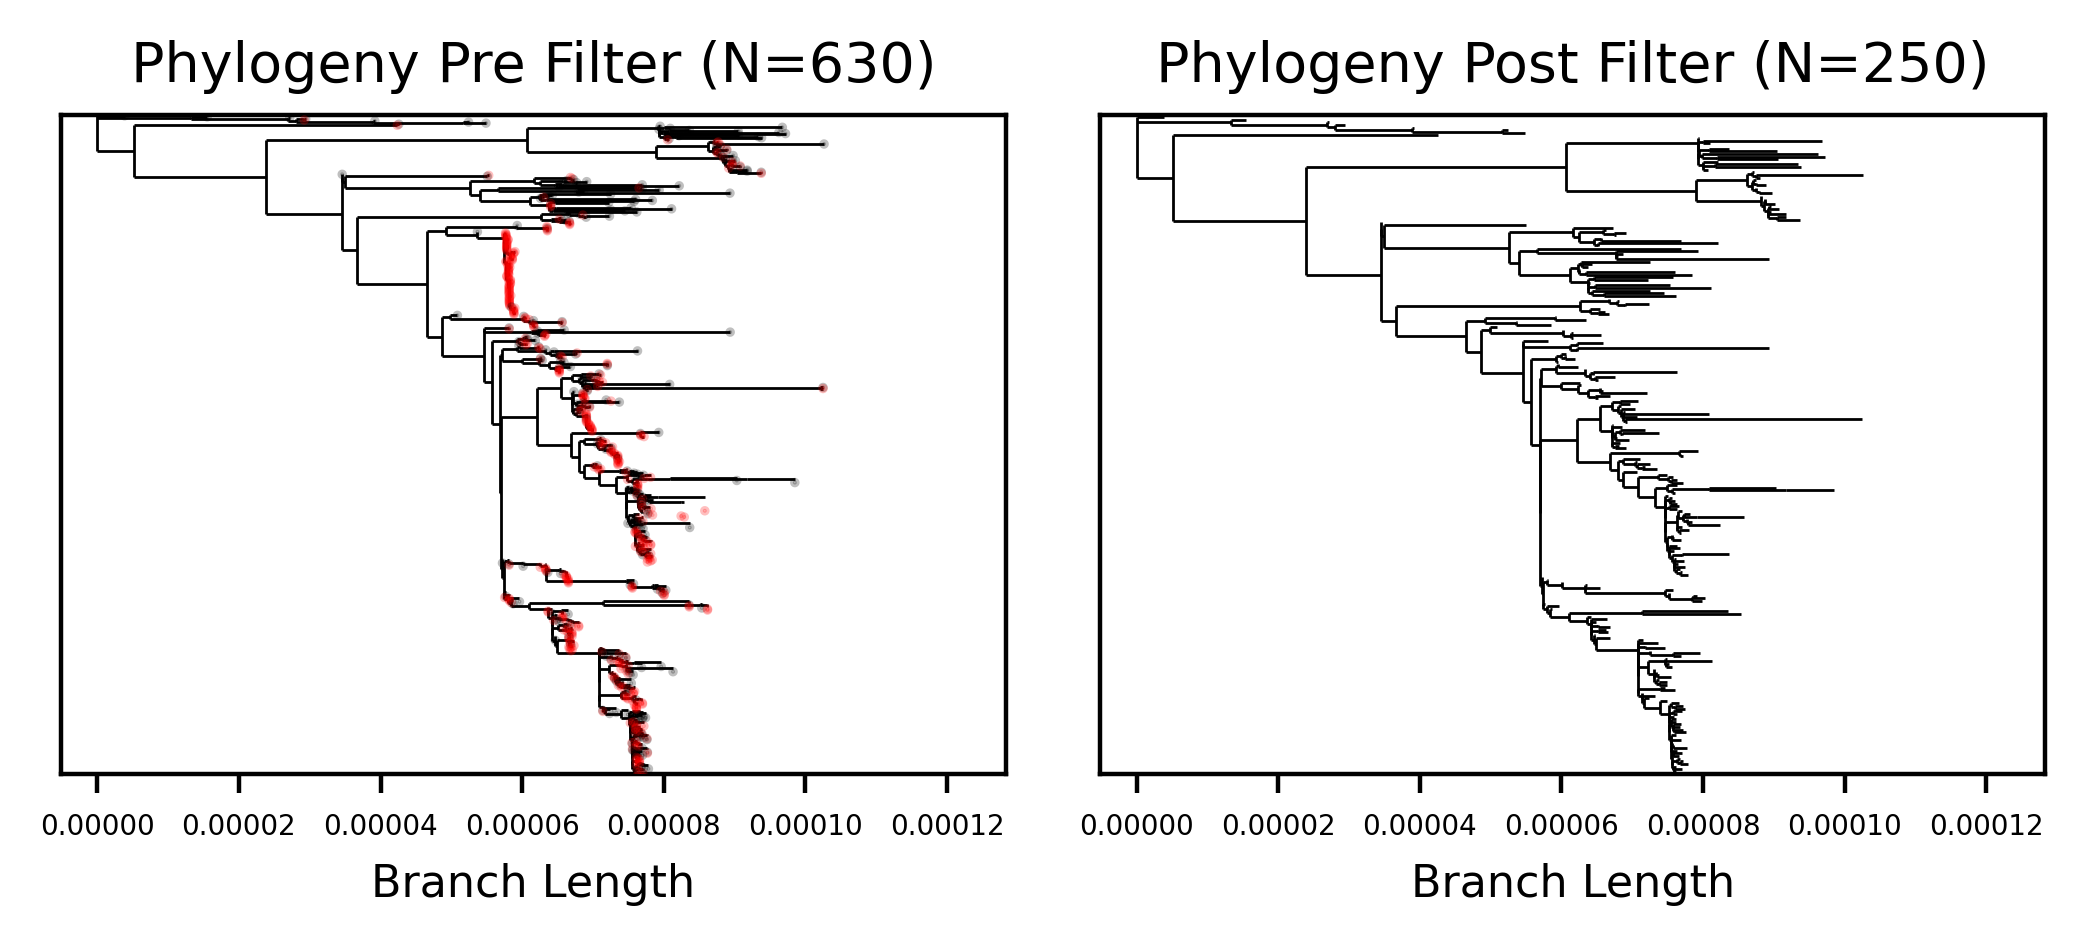

In [154]:
# Setup the figure
fig = plt.figure(dpi=dpi,
                 figsize=(figsize[0] * 1, figsize[1] * 1),
                 )

# Setup the grid
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])


# -----------------------------------------------------
# Axis 1: Phylogeny Pre-Filter
colors = []
# color nodes if filtered
for t in tree_pre.get_terminals():
    if t.name in treemmer_tips_keep:
        colors.append("black")
    else:
        colors.append("red")

Phylo.draw(tree_pre, 
        show_confidence=False, 
        label_func = lambda x: '',
        do_show=False,
        axes=ax1)

tip_data = tree_df_pre[(tree_df_pre["Branch_Support_Color"] == TERM_COL)]

ax1.scatter(data=tip_data, 
            x="coord_x", 
            y="coord_y", 
            s=0.5, 
            c=colors,
            edgecolor=colors,
            alpha=0.25,
            zorder=3,
           )

# Labels
ax1.set_xlabel("Branch Length")
ax1.set_yticks([])
ax1.set_ylabel('')
num_tips = len(tree_pre.get_terminals())
ax1.set_title("Phylogeny Pre Filter (N={})".format(num_tips))


Phylo.draw(tree, 
        show_confidence=False, 
        label_func = lambda x: '',
        do_show=False,
        axes=ax2)

# Labels
ax2.set_xlabel("Branch Length")
ax2.set_yticks([])
ax2.set_ylabel('')
num_tips = len(tree.get_terminals())
ax2.set_title("Phylogeny Post Filter (N={})".format(num_tips))

---
# Export

## Save Tree, Dataframe, and Alignment

In [11]:
# Tree
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + ".xml" )
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + ".nexus" )

Phylo.write(tree, out_path_xml, 'phyloxml')
Phylo.write(tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))
Phylo.write(tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dataframe
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
tree_df.to_csv(out_path_df, sep="\t")

# Alignment
out_path = os.path.join(outdir, SCRIPT_NAME + ".fasta")
AlignIO.write(treemmer_align, out_path, "fasta")

1

## Augur JSON

In [12]:
augur_dict = augur_export(
    tree_path=out_path_nwk, 
    aln_path=aln_path, 
    tree=tree, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord"],
    type_convert = {
        "Branch_Number" : (lambda x : str(x))
    },
)

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

KeyError: 'NODE0'

## Auspice JSON

In [ ]:
auspice_dict = auspice_export(
    tree=tree, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlons_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_remote_json)
print("Validation successful for remote JSON.")